In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

$$
\begin{array}{c}
Z =\beta M + \sqrt{1-\beta^2} \bullet \epsilon \\ \ \ \ \  = \sqrt{\rho} M + \sqrt{1-\rho} \bullet \epsilon \\ \\ U = N(Z), \ \tau = \frac{-ln(1-U)}{PD} \\
\end{array}
$$

 #### My Portfolio = (8mio loan)*100 + (20 mio loan)* 20
  #### 1-(a) Copula Corr = 0

In [2]:
def Gaussian_PF_Loss_density(my_port, copula_corr,
                             T, LGD, PD, sim_num = 10000,
                            Result_Riskcapital = False) :
    Total_num = len(my_port)
    corr = copula_corr
    m = np.random.normal(0,1,size = (1,sim_num))  ## Market Factor ##
    epsilon = np.random.normal(0,1,size = (Total_num,sim_num))  
    Z = np.sqrt(corr) * m + np.sqrt(1-corr) * epsilon
    U = norm.cdf(Z)
    tau = -np.log(1-U)/PD
    Simul_Loss_Mat = np.array(my_port).reshape(-1,1) * (tau<T) * LGD ## Simul Result Matrix##
    Total_Simul_Loss = Simul_Loss_Mat.sum(0)
    if Result_Riskcapital == False :
        return Total_Simul_Loss
    else : 
        EL = Total_Simul_Loss.mean()
        UEL = pd.Series(Total_Simul_Loss).quantile(0.999)
        Risk_Capital = UEL - EL
        return Total_Simul_Loss, Risk_Capital

def Gaussian_Default_Corr(copul_corr,T,LGD,PD,num_obligor,
                          Loss_Result = False , sim_num=10000,
                          Default_Rate_Result = False ,F = 100):
    ################################################
    ## Calculate the Gaussian Default Correlation ##
    ################################################
    Principal = np.array([F]*num_obligor).astype(np.int16)
    Total_num = len(Principal)
    m = np.random.normal(0,1,(1,sim_num)).astype(np.float32)
    epsilon = np.random.normal(0,1,(Total_num,sim_num)).astype(np.float32)
    Z = np.sqrt(copul_corr) * m + np.sqrt(1-copul_corr) * epsilon
    U = norm.cdf(Z)
    tau = -np.log(1-U)/PD
    Simul_Loss_Mat = Principal.reshape(-1,1)*(tau<T)*LGD
    X = (Simul_Loss_Mat>0).sum(0)                ## X is number of Default 
    Y = Total_num
    Default_Rate = (Simul_Loss_Mat>0).sum(0)/Y   ## Simulated Default Rate Path
    Joint_Prob = (X * (X-1) / (Y * (Y-1)))## P(A&B)    
    Default_Corr= (Joint_Prob - PD*PD)/(PD*(1-PD))
    if Loss_Result == False and Default_Rate_Result == False :
        return Default_Corr.mean()
    elif Loss_Result == True and Default_Rate_Result == False :
        return Default_Corr.mean() , X
    elif Loss_Result == False and Default_Rate_Result == True :
        return Default_Corr.mean(), Default_Rate
    else :
        return Default_Corr.mean(), X, Default_Rate
    
def Calibrate_Copula_Corr(actual_default_std,
                          PD, T, LGD, F = 100,
                          num_obligor = 2000,sim_num = 5000) :
    ########################
    ### Correlation Range ##
    Range = np.arange(0,1,0.02)
    ########################
    Default_std_lst = []
    for i in Range :
        copul_corr = i
        Principal = np.array([F]*num_obligor).astype(np.int16)
        Total_num = len(Principal)
        m = np.random.normal(0,1,(1,sim_num)).astype(np.float32)
        epsilon = np.random.normal(0,1,(Total_num,sim_num)).astype(np.float32)
        Z = np.sqrt(copul_corr) * m + np.sqrt(1-copul_corr) * epsilon
        U = norm.cdf(Z)
        tau = -np.log(1-U)/PD
        Simul_Loss_Mat = Principal.reshape(-1,1)*(tau<T)*LGD
        X = (Simul_Loss_Mat>0).sum(0)                ## X is number of Default 
        Y = Total_num
        Default_Rate = (Simul_Loss_Mat>0).sum(0)/Y   ## Simulated Default Rate Path
        Default_std_lst.append(Default_Rate.std())
    Copula_Corr = Range[(np.abs(np.array(Default_std_lst) - actual_default_std)).argmin()]
    return Copula_Corr    

In [3]:
my_port = [8]*100+[20]*20
TSL1 = Gaussian_PF_Loss_density(my_port, copula_corr=0, T=1, LGD=0.5, PD=0.012)

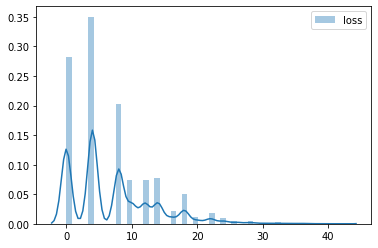

In [4]:
sns.distplot(TSL1, bins = 50, label = 'loss')
plt.legend(loc = 'best')
plt.show()

 #### 1-(b) Copula Corr = 0.3

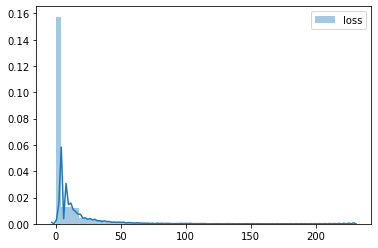

In [5]:
TSL2 = Gaussian_PF_Loss_density(my_port, copula_corr=0.3, T=1, LGD=0.5, PD=0.012)
sns.distplot(TSL2, bins = 50, label = 'loss')
plt.legend(loc = 'best')
plt.show()

 #### 1-(c) Calibrate Default Correlation

In [6]:
Def_Corr,Loss_Res, Default_Rate = Gaussian_Default_Corr(0.3,1,0.5,0.012,2000,
                                                        Loss_Result = True,
                                                       Default_Rate_Result=True)
Def_Corr

0.054454453947621585

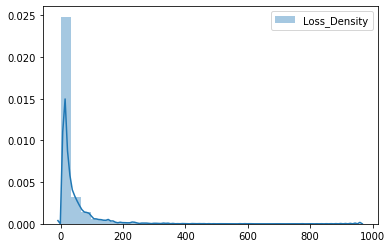

In [7]:
sns.distplot(Loss_Res, bins = 30, label = 'Loss_Density')
plt.legend(loc = 'best')
plt.show()

 #### 1-(d) Loss Histogram and Default Rate std

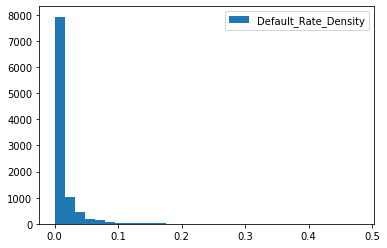

In [8]:
plt.hist(Default_Rate, bins = 30, label = 'Default_Rate_Density')
plt.legend(loc = 'best')
plt.show()

In [9]:
Default_Rate.std()

0.025359025302838435

 ##### 1-(e) Fitting the Copula Correlation with Actual Default std and Copula default std

In [10]:
Calibrated_Copul_Corr = Calibrate_Copula_Corr(actual_default_std = 0.02,                                              
                                              PD = 0.012, T= 1, LGD= 0.5, F = 100,
                                              num_obligor = 2000,sim_num = 5000)

In [11]:
Calibrated_Copul_Corr

0.22

 #### 2-(a) Risk_Capital of 120 loans PF (Copula Corr = 0 )

In [48]:
TSL1, Risk_Capital1 = Gaussian_PF_Loss_density(my_port, copula_corr=0, T=1, LGD=0.5, PD=0.012, Result_Riskcapital=True)
Risk_Capital1

26.9282

 #### 2-(b) Risk_Capital of 120 loans PF (Copula Corr = 0.3)

In [13]:
TSL2, Risk_Capital2 = Gaussian_PF_Loss_density(my_port, copula_corr=0.3, T=1, LGD=0.5, PD=0.012, Result_Riskcapital=True)
Risk_Capital2

153.08940000000203

 #### Risk Capital With Analytic Calculation

$$
\begin{array}{c}
WCDR(1yr,0.999, PD, \rho ) = N( \frac{ N^{-1}(PD) + \sqrt{\rho} N^{-1}(0.999) }
{\sqrt{1-\rho}   }  )\\\ Credit \ Risk \ Capital = VaR(0.999) - EL \\
\end{array}
$$

In [58]:
def Credit_VaR_Gaussian_Copula(my_port, copula_corr, LGD, PD, alpha = 0.001) :    
    Total_Principal = np.array(my_port).sum()
    ### Worst Case Default Rate ###
    WCDR = norm.cdf((norm.ppf(PD) + np.sqrt(copula_corr) * norm.ppf(1-alpha))/np.sqrt(1-copula_corr))
    UEL = Total_Principal * WCDR * LGD
    return UEL

def Credit_Risk_Capital_Gaussian_Copula(my_port, copula_corr, LGD, PD, alpha = 0.001) :
    Total_Principal = np.array(my_port).sum()
    WCDR = norm.cdf((norm.ppf(PD) + np.sqrt(copula_corr) * norm.ppf(1-alpha))/np.sqrt(1-copula_corr))
    UEL = Total_Principal * WCDR * LGD
    P_range = np.arange(0.001, 0.999, 0.001)
    Default_Rate = norm.cdf((norm.ppf(PD) + np.sqrt(copula_corr) * norm.ppf(P_range))/np.sqrt(1-copula_corr))
    Expected_Default_Rate = Default_Rate.mean()
    EL = Total_Principal * Expected_Default_Rate * LGD
    Risk_Capital = np.round(UEL,5) - np.round(EL,5)
    return Risk_Capital

In [57]:
Credit_Risk_Capital_Gaussian_Copula(my_port, copula_corr=0.3, LGD= 0.5, PD=0.012, alpha = 0.001).round(3)

142.996